<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="utf-8" />
  <title>Agentic AI Memory — LTM vs Checkpoints (Quick)</title>
  <meta name="viewport" content="width=device-width, initial-scale=1" />
</head>
<body style="font-family:system-ui,-apple-system,Segoe UI,Roboto,Inter,Arial; line-height:1.5; max-width:860px; margin:24px auto; padding:0 16px;">

  <h2 style="margin:18px 0 8px;">2) Long-Term Memory (LTM)</h2>
  <ul>
    <li><strong>Purpose:</strong> Remember facts, preferences, and past interactions across sessions.</li>
    <li><strong>Where stored:</strong> Durable stores (SQL/SQLite/Postgres) and often embeddings in a vector index.</li>
    <li><strong>How used:</strong> Retrieved (keyword/semantic) and injected into the prompt before the LLM call.</li>
    <li><strong>Example:</strong> “Your name is Raju and you prefer concise answers.”</li>
  </ul>

  <h2 style="margin:18px 0 8px;">3) Execution Memory / Checkpoints</h2>
  <ul>
    <li><strong>Purpose:</strong> Persist workflow state so an agent can resume exactly where it stopped.</li>
    <li><strong>Where stored:</strong> Framework-managed checkpoint backend (e.g., SQLite/Postgres) keyed by a thread/run id.</li>
    <li><strong>How used:</strong> Restores graph/node position and variables; not meant for semantic recall.</li>
    <li><strong>Example:</strong> Job crashed at step 3 of 5; on restart it continues at step 4.</li>
  </ul>

  <h3 style="margin:18px 0 8px;">Key Differences</h3>
  <table style="border-collapse:collapse; width:100%;">
    <thead>
      <tr>
        <th style="text-align:left; border-bottom:1px solid #ddd; padding:8px;">Aspect</th>
        <th style="text-align:left; border-bottom:1px solid #ddd; padding:8px;">Long-Term Memory</th>
        <th style="text-align:left; border-bottom:1px solid #ddd; padding:8px;">Execution / Checkpoints</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td style="padding:8px; border-bottom:1px dotted #eee;">Goal</td>
        <td style="padding:8px; border-bottom:1px dotted #eee;">Recall knowledge across sessions</td>
        <td style="padding:8px; border-bottom:1px dotted #eee;">Resume workflow progress</td>
      </tr>
      <tr>
        <td style="padding:8px; border-bottom:1px dotted #eee;">Data</td>
        <td style="padding:8px; border-bottom:1px dotted #eee;">Facts, summaries, embeddings</td>
        <td style="padding:8px; border-bottom:1px dotted #eee;">Graph state, node position, variables</td>
      </tr>
      <tr>
        <td style="padding:8px;">Usage</td>
        <td style="padding:8px;">Retrieved and added to the prompt</td>
        <td style="padding:8px;">Internally restored by the framework</td>
      </tr>
    </tbody>
  </table>
</body>
</html>


In [1]:
from typing import TypedDict, Annotated
from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain_tavily import TavilySearch
import gradio as gr
import datetime
from dotenv import load_dotenv
from langgraph.checkpoint.memory import InMemorySaver

load_dotenv()

a:\Indian_AI_Production_5\agentic_ai\agentic_ai_projects\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

In [3]:
db_path = r'A:\Indian_AI_Production_5\agentic_ai\agentic_ai_projects\data\memory.db'
conn = sqlite3.connect(db_path, check_same_thread=False)

sql_checkpoint = SqliteSaver(conn)

In [4]:
llm_gpt = init_chat_model(
    model="gpt-5", model_provider='openai')

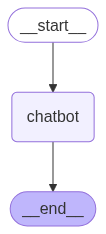

In [5]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)


def chatbot(state: State)->State:
    response = llm_gpt.invoke(state['messages'])
    return State(messages=[response])

graph_builder.add_node('chatbot', chatbot)

graph_builder.add_edge(START, 'chatbot')
graph_builder.add_edge('chatbot', END)

graph = graph_builder.compile(checkpointer=sql_checkpoint)
graph
    

In [6]:
config = {'configurable': {'thread_id': '1'}}
graph.invoke({'messages': ['I am Kaju']}, config=config)

{'messages': [HumanMessage(content='I am Kaju', additional_kwargs={}, response_metadata={}, id='17d5abf1-da0a-4f8a-85a5-44a1676f90ea'),
  AIMessage(content='Nice to meet you, Kaju! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 152, 'prompt_tokens': 10, 'total_tokens': 162, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 128, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-C69YCtUe7sQvKD8bcpL6GhFC9rGxa', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--ed30e464-8ba6-4157-b133-f320e82aa5f8-0', usage_metadata={'input_tokens': 10, 'output_tokens': 152, 'total_tokens': 162, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 128}}),
  HumanMessage(conten

In [7]:
graph.invoke({'messages': ['What is my name']}, config=config)

{'messages': [HumanMessage(content='I am Kaju', additional_kwargs={}, response_metadata={}, id='17d5abf1-da0a-4f8a-85a5-44a1676f90ea'),
  AIMessage(content='Nice to meet you, Kaju! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 152, 'prompt_tokens': 10, 'total_tokens': 162, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 128, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-C69YCtUe7sQvKD8bcpL6GhFC9rGxa', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--ed30e464-8ba6-4157-b133-f320e82aa5f8-0', usage_metadata={'input_tokens': 10, 'output_tokens': 152, 'total_tokens': 162, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 128}}),
  HumanMessage(conten

## After restart kernel

In [8]:
config = {'configurable': {'thread_id': '1'}}
graph.invoke({'messages': ['What is my name']}, config=config)

{'messages': [HumanMessage(content='I am Kaju', additional_kwargs={}, response_metadata={}, id='17d5abf1-da0a-4f8a-85a5-44a1676f90ea'),
  AIMessage(content='Nice to meet you, Kaju! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 152, 'prompt_tokens': 10, 'total_tokens': 162, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 128, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-C69YCtUe7sQvKD8bcpL6GhFC9rGxa', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--ed30e464-8ba6-4157-b133-f320e82aa5f8-0', usage_metadata={'input_tokens': 10, 'output_tokens': 152, 'total_tokens': 162, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 128}}),
  HumanMessage(conten

In [9]:
config = {'configurable': {'thread_id': '2'}}
graph.invoke({'messages': ['What is my name']}, config=config)

{'messages': [HumanMessage(content='What is my name', additional_kwargs={}, response_metadata={}, id='cb587005-d883-460a-baa3-9f43238a7fd0'),
  AIMessage(content='I don’t know your name yet. What would you like me to call you?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 218, 'prompt_tokens': 10, 'total_tokens': 228, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 192, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-C69cwXVWCBlFnmRnlqpMvRA37ulkP', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--db8d6135-6aab-4706-8d89-e3a11b4bfc31-0', usage_metadata={'input_tokens': 10, 'output_tokens': 218, 'total_tokens': 228, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 192}}),
 

In [10]:
# Get latest state for a thread_id
snap1 = graph.get_state(config)          # {'configurable': {'thread_id': '2'}}
print("sql_mem_1 messages:")
print(snap1.values.get("messages", []))

sql_mem_1 messages:
[HumanMessage(content='What is my name', additional_kwargs={}, response_metadata={}, id='cb587005-d883-460a-baa3-9f43238a7fd0'), AIMessage(content='I don’t know your name yet. What would you like me to call you?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 218, 'prompt_tokens': 10, 'total_tokens': 228, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 192, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-C69cwXVWCBlFnmRnlqpMvRA37ulkP', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--db8d6135-6aab-4706-8d89-e3a11b4bfc31-0', usage_metadata={'input_tokens': 10, 'output_tokens': 218, 'total_tokens': 228, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 192}

In [11]:
graph.invoke({'messages': ['what is AgentScope 1.0']}, config=config)

{'messages': [HumanMessage(content='What is my name', additional_kwargs={}, response_metadata={}, id='cb587005-d883-460a-baa3-9f43238a7fd0'),
  AIMessage(content='I don’t know your name yet. What would you like me to call you?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 218, 'prompt_tokens': 10, 'total_tokens': 228, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 192, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-C69cwXVWCBlFnmRnlqpMvRA37ulkP', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--db8d6135-6aab-4706-8d89-e3a11b4bfc31-0', usage_metadata={'input_tokens': 10, 'output_tokens': 218, 'total_tokens': 228, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 192}}),
 

In [12]:

graph.invoke({'messages': ['what is LuxDiT']}, config=config)

{'messages': [HumanMessage(content='What is my name', additional_kwargs={}, response_metadata={}, id='cb587005-d883-460a-baa3-9f43238a7fd0'),
  AIMessage(content='I don’t know your name yet. What would you like me to call you?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 218, 'prompt_tokens': 10, 'total_tokens': 228, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 192, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-C69cwXVWCBlFnmRnlqpMvRA37ulkP', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--db8d6135-6aab-4706-8d89-e3a11b4bfc31-0', usage_metadata={'input_tokens': 10, 'output_tokens': 218, 'total_tokens': 228, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 192}}),
 